In [1]:
import requests
from datetime import datetime

import os
from apiclient.http import MediaFileUpload, MediaIoBaseDownload
from google.oauth2 import service_account
from googleapiclient.discovery import build

def setup_gdrive(credentials_secret):
    with open('credentials.json', 'w') as f:
        f.write(os.environ[credentials_secret])
        
    # Load the credentials from the JSON key file
    credentials = service_account.Credentials.from_service_account_file(
        'credentials.json',
        scopes=['https://www.googleapis.com/auth/drive']
    )

    drive_service = build('drive', 'v3', credentials=credentials)
    return drive_service



In [123]:
with open('/Users/przivic/Downloads/quetiene-3acd3a3a2117.json') as f:
    credentials = f.read()

os.environ['GDRIVE_SECRET'] = credentials

In [124]:
drive_service = setup_gdrive('GDRIVE_SECRET')
response = drive_service.files().list().execute()

    


In [125]:
response = drive_service.files().list().execute()
files = response['files']
files

[{'kind': 'drive#file',
  'mimeType': 'text/plain',
  'id': '1s_j644Z1eR4av3X8UJGsj5xvlUsKhFmT',
  'name': 'demanda-enre-2024-02-11T12-1078.txt'},
 {'kind': 'drive#file',
  'mimeType': 'text/plain',
  'id': '1qUB52EP_sw3l22b3bR44wH8Vnc3NZSIt',
  'name': 'demanda-enre-2024-02-11T12-1077.txt'},
 {'kind': 'drive#file',
  'mimeType': 'text/plain',
  'id': '1hF8c7gO5JYkJw8oBroBrYuoP4zwb-VCi',
  'name': 'cortes-enre-2024-02-11T12.txt'},
 {'kind': 'drive#file',
  'mimeType': 'text/plain',
  'id': '1mRndJSlG3jHYjjrRJ3ZuTX1PKr96J4NY',
  'name': 'demanda-enre-2024-02-11T11-1078.txt'},
 {'kind': 'drive#file',
  'mimeType': 'text/plain',
  'id': '1-x1tdHhvH42Rrs5_aMdZwBkE9la1hak1',
  'name': 'demanda-enre-2024-02-11T11-1077.txt'},
 {'kind': 'drive#file',
  'mimeType': 'text/plain',
  'id': '1_j0MAbzi0kwQe8jeFeWVfcmfWTEn5w5b',
  'name': 'cortes-enre-2024-02-11T11.txt'},
 {'kind': 'drive#file',
  'mimeType': 'text/plain',
  'id': '1GXB6yDVwwrw_6GWv_fKdJ3_G7uvckXsl',
  'name': 'demanda-enre-2024-02-1

In [126]:
import os

if not os.path.exists('data'): os.makedirs('data')

for file in files:
    file_id = file['id']
    request = drive_service.files().get_media(fileId=file_id)
    fh = io.BytesIO()
    with open('data/' + file['name'], 'wb') as fh:
        downloader = MediaIoBaseDownload(fh, request)
        done = False
        while not done:
            status, done = downloader.next_chunk()
            print(f"Download {int(status.progress() * 100)}%. {file_id}")

Download 100%. 1s_j644Z1eR4av3X8UJGsj5xvlUsKhFmT
Download 100%. 1qUB52EP_sw3l22b3bR44wH8Vnc3NZSIt
Download 100%. 1hF8c7gO5JYkJw8oBroBrYuoP4zwb-VCi
Download 100%. 1mRndJSlG3jHYjjrRJ3ZuTX1PKr96J4NY
Download 100%. 1-x1tdHhvH42Rrs5_aMdZwBkE9la1hak1
Download 100%. 1_j0MAbzi0kwQe8jeFeWVfcmfWTEn5w5b
Download 100%. 1GXB6yDVwwrw_6GWv_fKdJ3_G7uvckXsl
Download 100%. 1dCneWk65Hf-8Idfvoc3GHH49tzMaCUBs
Download 100%. 1IAS_2R6ATGezGna48Wt9PenVZttums8D
Download 100%. 1RxCJzSkARqiHEH_e13Jert7qCMvgqmIM
Download 100%. 1akGhn0vwtsll4tQAsFMR7840IKwBXjiq
Download 100%. 1goEmTOpKdV24vtnvlLdnAxlBHa-1jLtP
Download 100%. 1wKtIOIWQ1AvxyQ2jXty_mnSc5nmMlo1y
Download 100%. 1yQHG1e8ZUfZrXDzXBAuffdPw8yTOCQcv
Download 100%. 1PPOuFWOkWcqYjTth2aapDUy24UWQ8waY
Download 100%. 1MCXPMaA5KB6y_l5Y6_Ge-g2aCQZ3icg4
Download 100%. 1mN-xy8Y2E60GZhc8UDypbELxbUkUa8pT
Download 100%. 16aTKyvDYSepCnaxe42aMsT-rfVnZSFGr
Download 100%. 1trN1AVgwTr_Lpbc7PxIS-UwP-gtQ3t8F
Download 100%. 1nK_IoJKIw3EstGv2pN94SlFKEgCiVlmO
Download 100%. 1xcF7

In [18]:
import json
import re
import os

def parse_fname_date(fname):
    date_pat = re.compile('(\d{4}-\d{2}-\d{2}T\d{2})')
    return datetime.strptime(date_pat.search(fname).group(0), '%Y-%m-%dT%H')

def parse_cortes(fname):
    with open(fname) as f:
        contents = f.read()

    var_pat = re.compile('addressPoints_Cuadro_D.*?=.*?(?P<lista>.*?);')
    lista = var_pat.search(contents).groupdict()['lista'].strip()[1:-1].strip()

    corte_pat = re.compile('(\[.*?\])')
    cortes = []
    fname_date = parse_fname_date(fname)
    keys = ['latitud', 'longitud', 'misc', 'descr']
    for corte_match in corte_pat.finditer(lista):
        corte = json.loads(corte_match.group(0))
        corte = dict(zip(keys, corte))
        
        lines = corte['descr'].split(',')
        descr_dict = {'tipo': lines[0], 'empresa': lines[1].strip()}
        for line in lines[2:]:
            colon_pos = line.find(':')
            k = line[:colon_pos]
            v = line[colon_pos:]
            descr_dict[k.strip().lower()] = v.strip()

        corte.update(descr_dict)
        corte['date_hour'] = fname_date

        cortes.append(corte)
        
    return cortes

In [54]:
def parse_demanda(fname):
    region = int(fname.split('-')[-1].split('.')[0])
    with open(fname) as f:
        res = json.load(f)
        for doc in res:
            doc['region'] = region
    return res

In [41]:
fname = 'data/' + os.listdir('data')[1]

In [42]:
fname

'data/demanda-enre-2024-02-11T07-1077.txt'

In [55]:
cortes = []
demanda = []

for fname in os.listdir('data'):
    if fname.startswith('cortes'):
        parsing_func = parse_cortes
        output_list = cortes
    else:
        parsing_func = parse_demanda
        output_list = demanda
        
    fname = 'data/' + fname
    output_list.extend(parsing_func(fname))
    

In [56]:
for doc in demanda:
    doc['fecha'] = datetime.strptime(doc['fecha'][:19], '%Y-%m-%dT%H:%M:%S')

In [57]:
import pandas as pd

demanda_df = pd.DataFrame(demanda)

In [73]:
demanda_df.drop_duplicates(subset=['fecha', 'region'], inplace=True)

In [74]:
len(demanda_df)

578

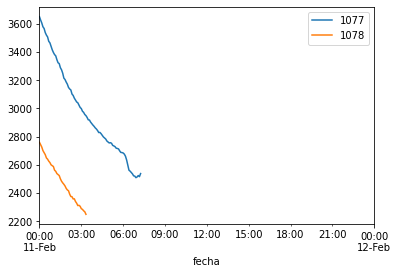

In [80]:
import matplotlib.pyplot as plt

for region in demanda_df.region.unique():
    demanda_df[demanda_df.region==region].set_index('fecha').demHoy.plot(label=str(region))
    
plt.legend(loc='best')

In [82]:
cortes_df = pd.DataFrame(cortes)